## 1. 영어로된 영화 리뷰 데이터 전처리 (40점)

* Kaggle에서 제공하는 Movie Review Dataset(https://www.kaggle.com/datasets/vipulgandhi/movie-review-dataset?resource=download)를 전처리하여 Vocab을 구성하시오.

    * 제공되는 코드는 해당 데이터를 실습에 사용한 NSMC 데이터의 형식으로 바꾸어주는 코드이다.
        * 단, 실습과 달리 train, val, test의 세 부분으로 나누어짐
    * Vocab 구성시 Whitespace tokenizer를 사용하여야 하며, Data cleaning, Text cleaning 과정을 거치지 않은 기본 Vocab을 생성하시오

**GRADING**
* Vocab 구현에 성공(+40)

In [1]:
import torch
import random
import numpy as np

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)


In [2]:
from requests import get
from os.path import exists


with open("train.txt", "r") as file:
    for i in range(5):
        print(file.readline())

with open("train.txt", "r", encoding="utf-8") as file:
    contents = file.read()
    lines = contents.split("\n")[1:]
    train_data = [line.split("\t") for line in lines if len(line) > 0]

with open("test.txt", "r", encoding="utf-8") as file:
    contents = file.read()
    lines = contents.split("\n")[1:]
    test_data = [line.split("\t") for line in lines if len(line) > 0]


with open("val.txt", "r", encoding="utf-8") as file:
    contents = file.read()
    lines = contents.split("\n")[1:]
    validation_data = [line.split("\t") for line in lines if len(line) > 0]

id	text	label

cv839_21467	assume nothing . the phrase is perhaps one of the most used of the 1990's , as first impressions and rumors are hardly ever what they seem to be . the phrase especially goes for oscar novak , an architect who is the main focus of three to tango , a delightful , funny romantic comedy about assumptions and being yourself . novak ( matthew perry ) , a shy , clumsy , chicago based architect , along with openly gay partner , peter steinberg ( oliver platt ) , fights for projects day in and day out . one of these is the job of restoring a popular building for charles newman ( dylan mcdermott ) , a rich , well-known businessman . charles immediately takes a liking to oscar , as he enjoys his personality and sense of humor . seeing oscar as someone he could trust , charles asks him to watch his girlfriend , an unpredictable , adventurous girl named amy post ( neve campbell ) , who makes a living by blowing glass . charles wants to know who she talks to , what she doe

In [3]:
# Build Your Own Vocabulary
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 32)
        self.fc1 = nn.Linear(32 * 100, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(-1, 32 * 100)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [5]:
import lightning as pl

class SentimentClassifierPL(pl.LightningModule):
    def __init__(self, sentiment_classifier):
        super(SentimentClassifierPL, self).__init__()
        self.model = sentiment_classifier
        self.loss = nn.CrossEntropyLoss()

        self.validation_step_outputs = []
        self.test_step_outputs = []
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        self.log("val_loss", loss)
        self.validation_step_outputs.append((loss, outputs, labels))
        return loss, outputs, labels

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x[0] for x in outputs]).mean()
        self.log("avg_val_loss", avg_loss)

        all_outputs = torch.cat([x[1] for x in outputs])
        all_labels = torch.cat([x[2] for x in outputs])
        all_preds = all_outputs.argmax(dim=1)
        accuracy = (all_preds == all_labels).float().mean()
        self.log("val_accuracy", accuracy)
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        self.log("test_loss", loss)
        self.test_step_outputs.append((loss, outputs, labels))
        return loss, outputs, labels

    def on_test_epoch_end(self):
        outputs = self.test_step_outputs
        avg_loss = torch.stack([x[0] for x in outputs]).mean()
        self.log("avg_test_loss", avg_loss)

        all_outputs = torch.cat([x[1] for x in outputs])
        all_labels = torch.cat([x[2] for x in outputs])
        all_preds = all_outputs.argmax(dim=1)
        accuracy = (all_preds == all_labels).float().mean()
        self.log("test_accuracy", accuracy)
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer

In [6]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
      # 토크나이징을 미리 해서 받음. 안하면 할때마다 여러번함
        label = int(self.data[index][1])
        tokens = self.data[index][0]

        token_ids = [self.vocab[token] if token in self.vocab else 1 for token in tokens]

        if len(token_ids) > 100:
            token_ids = token_ids[:100]
        else:
            token_ids = token_ids[:100] + [0] * (100 - len(token_ids))

        return torch.tensor(token_ids), torch.tensor(label)

In [7]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [8]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

def check_vocab_properties(vocab):
    print(f"Vocab size: {len(vocab)}")
    print(f"Vocab items: {list(vocab.items())[:5]}")


def check_performance(vocab,train_data, validation_data ,test_data, wandb_log_name):
    wandb_logger = WandbLogger(project="NLP", name=wandb_log_name, group="HW1")

    model = SentimentClassifier(len(vocab))
    pl_model = SentimentClassifierPL(model)

    train_dataset = SentimentDataset(train_data, vocab)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_dataset = SentimentDataset(validation_data, vocab)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
    test_dataset = SentimentDataset(test_data, vocab)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    trainer = pl.Trainer(max_epochs=1,
                     accelerator="cpu",
                     logger=wandb_logger
                     )

    trainer.fit(model=pl_model,
                train_dataloaders=train_loader,
                val_dataloaders=val_loader)

    trainer.test(dataloaders=test_loader)

    wandb.finish()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
from collections import Counter
from tqdm import tqdm

whitespace_vocab = {"[PAD]":0, "[UNK]":1}
whitespace_vocab_idx = 2

tokenizer = lambda x: x.split() # 띄어쓰기 기준이니깐 split

tokenized_train_dataset = []
tokenized_validation_dataset = []
tokenized_test_dataset = []

for data in train_data:
    tokens = tokenizer(data[1])
    labels = data[2]
    tokenized_train_dataset.append((tokens, labels))

for data in validation_data:
    tokens = tokenizer(data[1])
    labels = data[2]
    tokenized_validation_dataset.append((tokens, labels))

for data in test_data:
    tokens = tokenizer(data[1])
    labels = data[2]
    tokenized_test_dataset.append((tokens, labels))

for tokens, _ in tokenized_train_dataset:
    for token in tokens:
        if token not in whitespace_vocab:
            whitespace_vocab[token] = whitespace_vocab_idx
            whitespace_vocab_idx += 1

In [10]:
check_vocab_properties(whitespace_vocab)

Vocab size: 43031
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('assume', 2), ('nothing', 3), ('.', 4)]


## 2. 영어로된 영화 리뷰 데이터 분류 모델 학습 (30점)
* 실습에 사용한 모델 및 Dataset 객체를 통해 긍정 부정 분류 모델을 학습하시오.
    * 실습코드와 동일한 구조의 모델을 사용해야함
    * 실습코드와 동일한 Trainer 및 하이퍼 파라미터를 유지해야함
    * Train, Validation, Test 데이터를 모두 학습에 알맞게 사용할 것

**GRADING**
* 모델 구현 및 학습 (+25)
* Train, Validation, Test를 알맞게 사용 (+5)

In [11]:
# Train Models
check_performance(whitespace_vocab, tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset, "whitespace")

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'sentiment_classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['sentiment_classifier'])`.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using

INFO: 
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 1.7 M 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.789     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 1.7 M 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.789     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at ./NLP/z5h95rt4/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./NLP/z5h95rt4/checkpoints/epoch=0-step=22.ckpt
INFO: Loaded model weights from the checkpoint at ./NLP/z5h95rt4/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./NLP/z5h95rt4/checkpoints/epoch=0-step=22.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       avg_test_loss       │    0.7384284734725952     │
│       test_accuracy       │    0.5066666603088379     │
│         test_loss         │    0.7363940477371216     │
└───────────────────────────┴───────────────────────────┘

avg_test_loss,▁
avg_val_loss,▁
epoch,▁█
test_accuracy,▁
test_loss,▁
trainer/global_step,▁█
val_accuracy,▁
val_loss,▁
avg_test_loss,0.73843
avg_val_loss,0.72092
epoch,1


## 3. Vocab 개선 (30점)
* 상기 구축한 Vocab을 최적화 하여 모델의 성능을 개선하시오
    * 남이 구축한 Vocab을 가져오는 것을 제외, 모든 것을 허용
* 참고하면 좋은 것
    * 영어의 불용어(Stopword) : https://gist.github.com/sebleier/554280
    * 영어에 적합한 Tokenizer : NLTK 라이브러리 참고 (https://www.nltk.org/api/nltk.tokenize.html)
    * 영어의 lemmatizing 및 stemming : NLTK 라이브러리를 참고 (https://www.nltk.org/api/nltk.stem.html)
    * Regular Expression 사용시 유용한 사이트 : https://regexr.com/

**GRADING**
* 수업에 배운 내용을 적용 (+10)
* 적용된 Vocab을 통해 성능 개선 (+10)
* NLTK 등 외부 라이브러리의 tokenizer 및 다양한 정규화 기법을 사용 (+10)

In [12]:
# whitespace_vacab: 아무런 기법도 적용되지 않은 상태
check_vocab_properties(whitespace_vocab)

Vocab size: 43031
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('assume', 2), ('nothing', 3), ('.', 4)]


### 1. 등장빈도가 너무 적은 토큰 삭제

Lec02 TextPreprocessing에서 배운대로 먼저 등장빈도가 너무 적은 토큰을 삭제해준다.

그러기 위해서 `Counter()`를 이용해 `tokenized_train_dataset`에 어떤 토큰이 가장 많이 나타나는지 알아보자

In [13]:
# 등장빈도가 너무 적은 토큰 삭제
from collections import Counter


token_counter = Counter() # list 원소 개수 쉽게 알 수 있음
for tokens, _ in tokenized_train_dataset:
  token_counter.update(tokens)

In [14]:
len(token_counter)

43029

In [15]:
token_counter.most_common(10)

[(',', 54791),
 ('the', 53683),
 ('.', 46204),
 ('a', 26602),
 ('and', 24872),
 ('of', 23936),
 ('to', 22393),
 ('is', 17695),
 ('in', 15173),
 ('"', 12234)]

영어에서 가장 많이 사용하는 the, a, and of, is 등의 단어들이 높은 순위를 기록하였다.

또한 ','나 '.'와 같은 문장부호도 매우 많이 나타나는 것을 알 수 있었다.


In [16]:
token_counter.most_common()[-10:]

[('sena', 1),
 ('pedagogical', 1),
 ('sluts', 1),
 ('ice-pick', 1),
 ('wielders', 1),
 ('ghostbuster', 1),
 ('bazookas', 1),
 ('explosives', 1),
 ('busses', 1),
 ('bikinis', 1)]

반대로 가장 낮은 빈도로 등장하는 하위 10개 항목도 출력해보았다.

'bozookas'는 바주카포의 바주카 같은데 실제로 사용하는건 처음 본다..

In [17]:
import matplotlib.pyplot as plt

def plot_frequency_distribution(counter):
    plt.plot(counter.values())
    plt.ylabel('Token Frequency')
    plt.show()

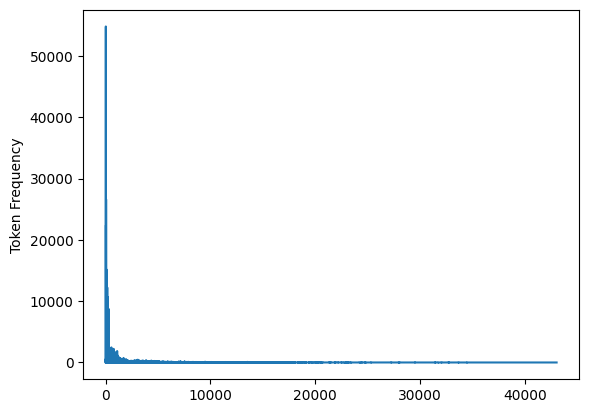

In [18]:
plot_frequency_distribution(token_counter)

단어들의 분포를 그래프로 그려보았다.

이건 Lec2 TextPreprocessing에서 본 그래프보다 더 극단적이다.

특정 단어만 많이 등장한다. 그리고 나머지 대부분 단어는 등장 빈도가 매우 적은 거 같다.

이걸 유지할 필요는 없다.

따라서, **등장빈도가 적은 단어를 제거해준다.**

In [19]:
min_count = 1
min1removed_vocab = {"[PAD]":0, "[UNK]":1}
min1removed_vocab_idx = 2

for token, count in token_counter.items():
    if count > min_count:
        min1removed_vocab[token] = min1removed_vocab_idx
        min1removed_vocab_idx += 1

In [20]:
check_vocab_properties(min1removed_vocab)

Vocab size: 23728
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('assume', 2), ('nothing', 3), ('.', 4)]


기존 whitespace_vocab과 비교해보면 사이즈가 거의 절반으로 줄어들었다.

```python
# 기존 whitespace_vocab
Vocab size: 43031
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('assume', 2), ('nothing', 3), ('.', 4)]
```

In [21]:
check_performance(min1removed_vocab, tokenized_train_dataset, tokenized_validation_dataset,tokenized_test_dataset, "whitespace_min_count_1")

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'sentiment_classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['sentiment_classifier'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: 
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 1.1 M 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.318     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 1.1 M 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.318     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: Restoring states from the checkpoint path at ./NLP/cspvsknl/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./NLP/cspvsknl/checkpoints/epoch=0-step=22.ckpt
INFO: Loaded model weights from the checkpoint at ./NLP/cspvsknl/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./NLP/cspvsknl/checkpoints/epoch=0-step=22.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       avg_test_loss       │    0.7082511186599731     │
│       test_accuracy       │    0.5633333325386047     │
│         test_loss         │    0.7139629125595093     │
└───────────────────────────┴───────────────────────────┘

avg_test_loss,▁
avg_val_loss,▁
epoch,▁█
test_accuracy,▁
test_loss,▁
trainer/global_step,▁█
val_accuracy,▁
val_loss,▁
avg_test_loss,0.70825
avg_val_loss,0.73982
epoch,1


놀라운 결과다. Vocab에서 등장 빈도가 낮은 단어만 제거했는데도 test_accuracy가 50%에서 56%로 크게 증가하였다.

그리고 학습 파라미터도 1.7M -> 1.1M으로 상당히 많이 줄어들었다.

In [22]:
whitespace_vocab

{'[PAD]': 0,
 '[UNK]': 1,
 'assume': 2,
 'nothing': 3,
 '.': 4,
 'the': 5,
 'phrase': 6,
 'is': 7,
 'perhaps': 8,
 'one': 9,
 'of': 10,
 'most': 11,
 'used': 12,
 "1990's": 13,
 ',': 14,
 'as': 15,
 'first': 16,
 'impressions': 17,
 'and': 18,
 'rumors': 19,
 'are': 20,
 'hardly': 21,
 'ever': 22,
 'what': 23,
 'they': 24,
 'seem': 25,
 'to': 26,
 'be': 27,
 'especially': 28,
 'goes': 29,
 'for': 30,
 'oscar': 31,
 'novak': 32,
 'an': 33,
 'architect': 34,
 'who': 35,
 'main': 36,
 'focus': 37,
 'three': 38,
 'tango': 39,
 'a': 40,
 'delightful': 41,
 'funny': 42,
 'romantic': 43,
 'comedy': 44,
 'about': 45,
 'assumptions': 46,
 'being': 47,
 'yourself': 48,
 '(': 49,
 'matthew': 50,
 'perry': 51,
 ')': 52,
 'shy': 53,
 'clumsy': 54,
 'chicago': 55,
 'based': 56,
 'along': 57,
 'with': 58,
 'openly': 59,
 'gay': 60,
 'partner': 61,
 'peter': 62,
 'steinberg': 63,
 'oliver': 64,
 'platt': 65,
 'fights': 66,
 'projects': 67,
 'day': 68,
 'in': 69,
 'out': 70,
 'these': 71,
 'job': 72,
 

### 불용어 제거

그런데 the, a, and, of .. 이런 단어는 문장에서 빼고 봐도 되는 불용어이다.

이것도 제거해주자.



In [23]:
!pip install nltk

In [24]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
token_counter = Counter()

for tokens, _ in tokenized_train_dataset:
  token_counter.update(tokens)

token_counter.most_common(10)

[(',', 54791),
 ('the', 53683),
 ('.', 46204),
 ('a', 26602),
 ('and', 24872),
 ('of', 23936),
 ('to', 22393),
 ('is', 17695),
 ('in', 15173),
 ('"', 12234)]

In [44]:
tokenized_data = list(token_counter.items())
print(tokenized_data) # 불용어 있음

# NLTK에서 영어 불용어 가져오기
stop_words = set(stopwords.words('english'))

# 토큰화된 데이터에서 불용어 제거
filtered_data = [(word,counter) for word,counter  in tokenized_data if word.lower() not in stop_words]
print("filtered_data", filtered_data)
print("len", len(filtered_data))

# 불용어 제거한 뒤 token_counter로 갯수 세어 보기
token_counter = Counter(dict(filtered_data)) #
token_counter.most_common(10) # 불용어 제거됨

[('assume', 32), ('nothing', 564), ('.', 46204), ('the', 53683), ('phrase', 15), ('is', 17695), ('perhaps', 322), ('one', 3878), ('of', 23936), ('most', 1585), ('used', 274), ("1990's", 4), (',', 54791), ('as', 7970), ('first', 1285), ('impressions', 4), ('and', 24872), ('rumors', 14), ('are', 4908), ('hardly', 86), ('ever', 517), ('what', 2170), ('they', 3073), ('seem', 397), ('to', 22393), ('be', 4323), ('especially', 328), ('goes', 447), ('for', 7055), ('oscar', 161), ('novak', 5), ('an', 4053), ('architect', 6), ('who', 3817), ('main', 286), ('focus', 103), ('three', 419), ('tango', 24), ('a', 26602), ('delightful', 39), ('funny', 577), ('romantic', 161), ('comedy', 561), ('about', 2478), ('assumptions', 4), ('being', 925), ('yourself', 74), ('(', 8258), ('matthew', 91), ('perry', 20), (')', 8351), ('shy', 25), ('clumsy', 21), ('chicago', 35), ('based', 256), ('along', 371), ('with', 7471), ('openly', 12), ('gay', 70), ('partner', 70), ('peter', 177), ('steinberg', 1), ('oliver', 5

[(',', 54791),
 ('.', 46204),
 ('"', 12234),
 (')', 8351),
 ('(', 8258),
 ('film', 6230),
 ('one', 3878),
 ('movie', 3790),
 ('?', 2622),
 ('like', 2457)]

불용어가 제거되었다.

In [45]:
min_count = 1
no_stopword_vocab = {"[PAD]":0, "[UNK]":1}
no_stopword_idx = 2

for token, count in token_counter.items():
    if count > min_count:
        no_stopword_vocab[token] = no_stopword_idx
        no_stopword_idx += 1

In [46]:
check_vocab_properties(no_stopword_vocab)

Vocab size: 23567
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('assume', 2), ('nothing', 3), ('.', 4)]


In [47]:
check_performance(no_stopword_vocab, tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset, "no_stopword_vocab")

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: 
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 1.1 M 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.298     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 1.1 M 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.298     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: Restoring states from the checkpoint path at ./NLP/4jotyi6a/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./NLP/4jotyi6a/checkpoints/epoch=0-step=22.ckpt
INFO: Loaded model weights from the checkpoint at ./NLP/4jotyi6a/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./NLP/4jotyi6a/checkpoints/epoch=0-step=22.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       avg_test_loss       │    0.7002665996551514     │
│       test_accuracy       │    0.5266666412353516     │
│         test_loss         │    0.6994579434394836     │
└───────────────────────────┴───────────────────────────┘

avg_test_loss,▁
avg_val_loss,▁
epoch,▁█
test_accuracy,▁
test_loss,▁
trainer/global_step,▁█
val_accuracy,▁
val_loss,▁
avg_test_loss,0.70027
avg_val_loss,0.69422
epoch,1


불용어를 제거하고 모델을 평가해보았는데, 오히려 test_accuracy가 감소했다.

나의 개인적인 생각은 다음과 같다.

불용어 자체가 매우 많이 나오는 단어인데 이를 vocab에서 제거해버리면
validation이나 test에서 UNK가 오히려 많아지기 때문에 성능이 감소한 것이라고 생각한다.

### Lemmatizing 적용해보기

In [30]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [31]:
st1 = PorterStemmer()
st2 = LancasterStemmer()

In [32]:
tokenized_data[:10] # 불용어를 제거하지 않은 데이터

[('assume', 32),
 ('nothing', 564),
 ('.', 46204),
 ('the', 53683),
 ('phrase', 15),
 ('is', 17695),
 ('perhaps', 322),
 ('one', 3878),
 ('of', 23936),
 ('most', 1585)]

이제 Lemmatization을 해준다.

In [33]:
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()

In [34]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [35]:
token_counter = Counter(dict(tokenized_data))
print(token_counter.most_common(10))
print(len(token_counter))

[(',', 54791), ('the', 53683), ('.', 46204), ('a', 26602), ('and', 24872), ('of', 23936), ('to', 22393), ('is', 17695), ('in', 15173), ('"', 12234)]
43029


In [36]:
lemmatizer = WordNetLemmatizer()

기존에는 is였던 것이 be 동사 원형으로 바뀐 것을 보아 lemmatizing 되었다.

In [37]:
word_list = [word for word, freq in token_counter.items() for _ in range(freq)]
print(word_list[:10])

['assume', 'assume', 'assume', 'assume', 'assume', 'assume', 'assume', 'assume', 'assume', 'assume']


In [38]:
from nltk import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [39]:
pos_tags = pos_tag(word_list)
lemmatized_tokens = []

for word, pos_tag in pos_tags:
  wn_pos = 'n'  # Default to noun
  if pos_tag.startswith('V'):  # Verb
      wn_pos = 'v'
  elif pos_tag.startswith('J'):  # Adjective
      wn_pos = 'a'
  elif pos_tag.startswith('R'):  # Adverb
      wn_pos = 'r'

  lemma = lemmatizer.lemmatize(word, pos=wn_pos)
  lemmatized_tokens.append(lemma)


In [40]:
lemmatized_counter = Counter(lemmatized_tokens)
print(lemmatized_counter)

Counter({',': 54791, 'the': 53683, '.': 46204, 'be': 33736, 'a': 26604, 'and': 24872, 'of': 23936, 'to': 22393, 'in': 15173, '"': 12234, 'that': 10652, 'it': 10317, ')': 8351, '(': 8258, 'have': 8225, 'as': 8019, 'with': 7471, 'film': 7380, 'for': 7055, 'his': 6756, 'this': 6744, 'but': 6010, 'he': 5344, 'i': 5272, 'on': 5101, 'movie': 4578, 'by': 4275, 'an': 4053, 'one': 3991, 'not': 3892, 'who': 3820, 'do': 3562, 'at': 3533, 'from': 3508, 'you': 3126, 'her': 3111, 'they': 3073, 'all': 2925, 'make': 2885, '?': 2622, 'character': 2598, 'like': 2586, "it's": 2582, 'so': 2556, 'about': 2478, 'out': 2470, 'get': 2455, 'more': 2393, 'when': 2323, 'which': 2234, 'their': 2221, 'up': 2191, 'what': 2170, ':': 2169, 'see': 2168, 'or': 2150, 'some': 2109, 'go': 2063, 'just': 2032, 'there': 1961, 'if': 1959, 'she': 1921, 'him': 1882, 'time': 1880, 'into': 1864, 'even': 1856, 'scene': 1847, 'well': 1814, 'only': 1746, 'than': 1708, 'no': 1683, 'we': 1674, 'good': 1645, 'story': 1621, 'can': 1617,

In [51]:
min_count = 1
lem_vocab = {"[PAD]":0, "[UNK]":1}
lem_vocab_idx = 2

for token, count in lemmatized_counter.items():
  if count > min_count:
    lem_vocab[token] = lem_vocab_idx
    lem_vocab_idx += 1


In [54]:
check_vocab_properties(lem_vocab)

Vocab size: 19682
Vocab items: [('[PAD]', 0), ('[UNK]', 1), ('assume', 2), ('nothing', 3), ('.', 4)]


In [55]:
check_performance(lem_vocab, tokenized_train_dataset, tokenized_validation_dataset, tokenized_test_dataset, "lem_vocab")

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: 
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 950 K 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
950 K     Trainable params
0         Non-trainable params
950 K     Total params
3.801     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                | Params
----------------------------------------------
0 | model | SentimentClassifier | 950 K 
1 | loss  | CrossEntropyLoss    | 0     
----------------------------------------------
950 K     Trainable params
0         Non-trainable params
950 K     Total params
3.801     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO: Restoring states from the checkpoint path at ./NLP/yvekwmcn/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./NLP/yvekwmcn/checkpoints/epoch=0-step=22.ckpt
INFO: Loaded model weights from the checkpoint at ./NLP/yvekwmcn/checkpoints/epoch=0-step=22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./NLP/yvekwmcn/checkpoints/epoch=0-step=22.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       avg_test_loss       │    0.7007430791854858     │
│       test_accuracy       │    0.5199999809265137     │
│         test_loss         │    0.7028807997703552     │
└───────────────────────────┴───────────────────────────┘

avg_test_loss,▁
avg_val_loss,▁
epoch,▁█
test_accuracy,▁
test_loss,▁
trainer/global_step,▁█
val_accuracy,▁
val_loss,▁
avg_test_loss,0.70074
avg_val_loss,0.69775
epoch,1


성능이 크게 개선되진 않았다.

이전에 등장빈도가 1인 단어만 제거한 vocab인 min1removed가 더 좋은 성능을 보였다.

## 4. 왜 Vocab에 따라 성능이 달라지는가? (Bonus 20점) -> 보고서에 작성하였습니다.

* 실습 및 과제를 통해 Vocab에 따라 성능이 차이남을 확인할 수 있음
* 왜 성능이 하락하는지에 대한 자신의 생각을 기술하시오

**GRADING**
* 자신의 생각을 기술 함 (+10)
* 자신의 생각에 근거를 제시함 (+10)


흰트 : Vocab은 **Train 데이터를 통해서 구축**하여 Train, Validation, Test 데이터셋 모두에 사용함 + 단어가 Vocab에 없다면 **Unknown token**을 그자리에 대체함

주의! 흰트로 추론 가능한 이유 이외에도 다양한 이유가 존재. 자유롭게 기술